In [1]:

import pandas as pd
from scipy.sparse import csr_matrix
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import math
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
ratings_df = pd.read_csv("dataset/ratings_matrix.csv", nrows=2517)
ratings_df = ratings_df.drop(ratings_df.columns[0], axis=1)
ratings_df = ratings_df.fillna(0)

ratings_sparse_mat = csr_matrix(ratings_df.values)
rows, cols = ratings_sparse_mat.nonzero()

## Convert the non-zero values into a 1D array
ratings = ratings_sparse_mat[rows, cols].A1

In [3]:
nonzero_data = [(int(r), int(c), int(v)) for r, c, v in zip(rows, cols, ratings)]
random.seed(42)
random.shuffle(nonzero_data)

In [4]:
dataset_length = len(nonzero_data)
val_percentage = 0.2

train_last_idx = int((1-val_percentage) * dataset_length)

train_data = nonzero_data[:train_last_idx]
val_data = nonzero_data[train_last_idx:]

In [5]:
train_data[0] ## this will have the format of (image_id, user_id, rating)

(552, 16, 5)

## Collaborative Filtering

In [6]:
## User-user similarity matrix
def compute_user_similarity(ratings_matrix):
    similarity = cosine_similarity(ratings_matrix)
    np.fill_diagonal(similarity, 0)
    return similarity

In [7]:
## Fills the sparse matrix with the predicted values
def predict_user_cf(ratings_matrix, similarity_matrix, k=10):
    n_users, n_items = ratings_matrix.shape
    ratings_array = ratings_matrix.toarray()
    predicted_ratings = np.zeros((n_users, n_items))

    for user_idx in range(n_users):
        # Get top-k similar users
        user_similarities = similarity_matrix[user_idx]
        top_k_users = np.argsort(user_similarities)[::-1][:k]

        for item_idx in range(n_items):
            if ratings_array[user_idx, item_idx] > 0: ## User has already rated this item
                predicted_ratings[user_idx, item_idx] = ratings_array[user_idx, item_idx]
                continue

            sim_users_ratings = ratings_array[top_k_users, item_idx]
            sim_users_sims = user_similarities[top_k_users]

            # Filter out users who haven't rated this item
            mask = sim_users_ratings > 0
            sim_users_ratings = sim_users_ratings[mask]
            sim_users_sims = sim_users_sims[mask]

            if len(sim_users_ratings) > 0:
                predicted_ratings[user_idx, item_idx] = np.sum(sim_users_ratings * sim_users_sims) / (np.sum(sim_users_sims) + 1e-10)

    return predicted_ratings

In [8]:
def precision_recall_at_k(predictions, k=10, threshold=7):
    n_users = predictions.shape[0]
    precision_scores = []
    recall_scores = []

    for user_idx in range(n_users):
        relevant_items = set()
        for image_id, user_id, rating in val_data:
            if user_id == user_idx and rating >= threshold:
                relevant_items.add(image_id)

        # Skip users with no relevant items
        if not relevant_items:
            continue

        # Get top-k recommendations
        user_ratings = predictions[user_idx]
        for image_id, user_id, rating in train_data:
            if user_id == user_idx:
                user_ratings[image_id] = -1
        top_k_items = np.argsort(user_ratings)[::-1][:k]
        top_k_items = set(top_k_items)

        # Calculate metrics
        n_rel_and_rec = len(relevant_items.intersection(top_k_items))

        precision = n_rel_and_rec / k if k != 0 else 0
        recall = n_rel_and_rec / len(relevant_items) if len(relevant_items) != 0 else 0

        precision_scores.append(precision)
        recall_scores.append(recall)

    avg_precision = np.mean(precision_scores) if precision_scores else 0
    avg_recall = np.mean(recall_scores) if recall_scores else 0

    return avg_precision, avg_recall

In [9]:
# Evaluate the model using train/val split
def evaluate_cf_model(train_data, val_data, n_users, n_items):
    ## Create training matrix
    train_matrix = np.zeros((n_items, n_users))
    for image_id, user_id, rating in train_data:
        train_matrix[image_id, user_id] = rating

    train_matrix_sparse = csr_matrix(train_matrix)

    ## Compute user similarity matrix and perform prediction
    similarity_matrix = compute_user_similarity(train_matrix_sparse.T)
    predictions = predict_user_cf(train_matrix_sparse.T, similarity_matrix, k=10) ## Fill the sparse matrix with the predicted values

    ## Recall and precision @ k
    precision, recall = precision_recall_at_k(predictions, k=10, threshold=7)

    ## Calculate the error
    val_predictions = []
    val_true_ratings = []

    for image_id, user_id, rating in val_data:
        predicted = predictions[user_id, image_id]
        if predicted > 0:
            val_predictions.append(predicted)
            val_true_ratings.append(rating)

    rmse = math.sqrt(mean_squared_error(val_true_ratings, val_predictions))
    mae = np.mean(np.abs(np.array(val_predictions) - np.array(val_true_ratings)))
    return rmse, mae, precision, recall


In [10]:
n_items, n_users = ratings_df.shape

rmse, mae, precision, recall = evaluate_cf_model(train_data, val_data, n_users, n_items)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

RMSE: 1.3539
MAE: 0.7950
Precision: 0.1400
Recall: 0.0520


## Two Towers

In [11]:
img_text_embeddings = pd.read_csv("dataset/img_text_embeddings.csv")

embeddings_df = img_text_embeddings[['image_key', 'text_embedding', 'image_embedding']].copy()
embeddings_df['image_path'] = embeddings_df['image_key'].apply(lambda x: f"dataset/images/{x}.jpg")
embeddings_df = embeddings_df.drop(columns=['image_key'])
embeddings_df.head(2)

,text_embedding,image_embedding,image_path
0,"[0.03458784520626068, 0.4830687940120697, -0.0...","[0.12177003175020218, 0.12389735877513885, -0....",dataset/images/2.jpg
1,"[0.08950722217559814, 0.051412321627140045, -0...","[0.076620914041996, 0.6227577328681946, -0.115...",dataset/images/3.jpg


In [12]:
import ast

embeddings_df["text_embedding"] = embeddings_df["text_embedding"].apply(ast.literal_eval)
embeddings_df["image_embedding"] = embeddings_df["image_embedding"].apply(ast.literal_eval)

In [13]:
class TwoTowerModel(nn.Module):
    def __init__(self, embedding_dim=512):
        super(TwoTowerModel, self).__init__()
        self.user_tower = nn.Sequential(nn.Linear(embedding_dim, 256), nn.ReLU(),
                                        nn.Linear(256, 128))
        self.item_tower = nn.Sequential(nn.Linear(embedding_dim, 256), nn.ReLU(),
                                        nn.Linear(256, 128))

    def forward(self, user_emb, item_emb):
        user_repr = self.user_tower(user_emb)
        item_repr = self.item_tower(item_emb)
        return torch.cosine_similarity(user_repr, item_repr, dim=1)

In [14]:
def prepare_data(data, embeddings_df):
    text_embeddings = torch.tensor(embeddings_df['text_embedding'].tolist()).float()
    image_embeddings = torch.tensor(embeddings_df['image_embedding'].tolist()).float()

    user_embs = []
    item_embs = []
    ratings = []

    for image_id, user_id, rating in data:
        user_embs.append(text_embeddings[image_id])
        item_embs.append(image_embeddings[image_id])
        ratings.append(rating)

    return torch.stack(user_embs), torch.stack(item_embs), torch.tensor(ratings).float()

def prepare_two_tower_data(train_data, val_data, embeddings_df):
    """
    Prepare training and validation data for the two-tower model
    """
    train_user_embs, train_item_embs, train_ratings = prepare_data(train_data, embeddings_df)
    val_user_embs, val_item_embs, val_ratings = prepare_data(val_data, embeddings_df)

    return (train_user_embs, train_item_embs, train_ratings), (val_user_embs, val_item_embs, val_ratings)

In [15]:
def train_two_tower_model(model, train_data, val_data, num_epochs=10, batch_size=32):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    train_user_embs, train_item_embs, train_ratings = train_data
    val_user_embs, val_item_embs, val_ratings = val_data

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # Training
        for i in range(0, len(train_ratings), batch_size):
            batch_user_embs = train_user_embs[i:i+batch_size]
            batch_item_embs = train_item_embs[i:i+batch_size]
            batch_ratings = train_ratings[i:i+batch_size]

            optimizer.zero_grad()
            predictions = model(batch_user_embs, batch_item_embs)
            loss = criterion(predictions, batch_ratings / 10.0)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / (len(train_ratings) / batch_size)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_predictions = model(val_user_embs, val_item_embs)
            val_loss = criterion(val_predictions, val_ratings / 10.0)
            val_losses.append(val_loss.item())

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {val_loss.item():.4f}')
    return train_losses, val_losses

In [16]:
def evaluate_two_tower_model(model, val_data_tensors, val_data_original, embeddings_df):
    model.eval()
    val_user_embs, val_item_embs, val_ratings = val_data_tensors

    with torch.no_grad():
        predictions = model(val_user_embs, val_item_embs)
        predictions = predictions * 10.0

        # Calculate RMSE and MAE
        rmse = math.sqrt(mean_squared_error(val_ratings.numpy(), predictions.numpy()))
        mae = np.mean(np.abs(predictions.numpy() - val_ratings.numpy()))

        # Calculate Precision and Recall@k
        precision, recall = precision_recall_at_k_two_tower(
            model, embeddings_df, val_data_original, k=10, threshold=7)

    return rmse, mae, precision, recall

def precision_recall_at_k_two_tower(model, embeddings_df, val_data_original, k=10, threshold=7):
    model.eval()
    text_embeddings = torch.tensor(embeddings_df['text_embedding'].tolist()).float()
    image_embeddings = torch.tensor(embeddings_df['image_embedding'].tolist()).float()

    precision_scores = []
    recall_scores = []

    # Group validation data by user
    user_relevant_items = {}
    for image_id, user_id, rating in val_data_original:
        if rating >= threshold:
            if user_id not in user_relevant_items:
                user_relevant_items[user_id] = set()
            user_relevant_items[user_id].add(image_id)

    with torch.no_grad():
        for user_id, relevant_items in user_relevant_items.items():
            if not relevant_items:
                continue

            # Get predictions for all items for this user
            user_emb = text_embeddings[list(relevant_items)[0]]  # Use first relevant item's text embedding
            user_emb = user_emb.unsqueeze(0).repeat(len(image_embeddings), 1)

            predictions = model(user_emb, image_embeddings)

            # Get top k predictions
            top_k_items = torch.argsort(predictions, descending=True)[:k]
            recommended_items = set(top_k_items.numpy())

            # Calculate metrics
            n_rel_and_rec = len(relevant_items.intersection(recommended_items))
            precision = n_rel_and_rec / k
            recall = n_rel_and_rec / len(relevant_items)

            precision_scores.append(precision)
            recall_scores.append(recall)

    avg_precision = np.mean(precision_scores) if precision_scores else 0
    avg_recall = np.mean(recall_scores) if recall_scores else 0

    return avg_precision, avg_recall

In [17]:
EMBEDDING_DIMS = 512
model = TwoTowerModel(embedding_dim=EMBEDDING_DIMS)

train_data_tensors, val_data_tensors = prepare_two_tower_data(train_data, val_data, embeddings_df)
train_losses, val_losses = train_two_tower_model(model, train_data_tensors, val_data_tensors)
rmse, mae, precision, recall = evaluate_two_tower_model(model, val_data_tensors, val_data, embeddings_df)

print(f"Two-Tower Model Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Precision@10: {precision:.4f}")
print(f"Recall@10: {recall:.4f}")

Epoch 1/10:
Training Loss: 0.0280
Validation Loss: 0.0196
Epoch 2/10:
Training Loss: 0.0192
Validation Loss: 0.0196
Epoch 3/10:
Training Loss: 0.0186
Validation Loss: 0.0198
Epoch 4/10:
Training Loss: 0.0176
Validation Loss: 0.0202
Epoch 5/10:
Training Loss: 0.0164
Validation Loss: 0.0206
Epoch 6/10:
Training Loss: 0.0156
Validation Loss: 0.0211
Epoch 7/10:
Training Loss: 0.0148
Validation Loss: 0.0217
Epoch 8/10:
Training Loss: 0.0141
Validation Loss: 0.0225
Epoch 9/10:
Training Loss: 0.0136
Validation Loss: 0.0250
Epoch 10/10:
Training Loss: 0.0132
Validation Loss: 0.0271
Two-Tower Model Results:
RMSE: 1.6477
MAE: 1.3320
Precision@10: 0.0200
Recall@10: 0.0099


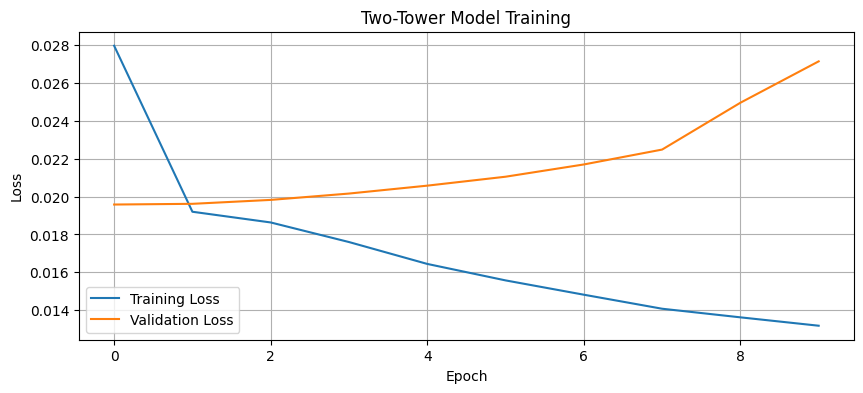

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Two-Tower Model Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Content Filtering

## Low Rank Matrix Completion

In [19]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device='cuda' if torch.cuda.is_available() else 'cpu'

# Average text + image embedding into one feature vector
embeddings_df['text_embedding'] = embeddings_df['text_embedding'].apply(np.array)
embeddings_df['image_embedding'] = embeddings_df['image_embedding'].apply(np.array)

embeddings_df['combined_embedding'] = embeddings_df.apply(
    lambda row: (row['text_embedding'] + row['image_embedding']) / 2,
    axis=1
)

# Create a single 2D feature matrix
features = np.stack(embeddings_df['combined_embedding'].values)  # shape: [n_items, embedding_dim]
feature_dim = features.shape[1]  # number of features per item


# Create train_mask and val_mask
n_items = max([x[0] for x in train_data + val_data]) + 1
n_users = max([x[1] for x in train_data + val_data]) + 1

train_mask = np.zeros((n_items, n_users), dtype=bool)
val_mask = np.zeros((n_items, n_users), dtype=bool)

for i, j, _ in train_data:
    train_mask[i, j] = True

for i, j, _ in val_data:
    val_mask[i, j] = True


# Create fixed projection layer
def create_fixed_projection(feature_dim, rank):
    torch.manual_seed(SEED)
    proj = torch.nn.Linear(feature_dim, rank).to(device)
    torch.nn.init.xavier_uniform_(proj.weight)
    proj.bias.data.fill_(0)
    return proj

In [20]:
def precision_recall_at_k_lowrank(predictions, train_data, val_data, k=10, threshold=7):
    from collections import defaultdict

    train_rated = defaultdict(set)
    for img, user, _ in train_data:
        train_rated[user].add(img)

    val_relevant = defaultdict(set)
    for img, user, rating in val_data:
        if rating >= threshold:
            val_relevant[user].add(img)

    precisions, recalls = [], []

    for user in val_relevant:
        user_preds = predictions[:, user].copy()
        user_preds[list(train_rated[user])] = -np.inf  # mask seen items
        top_k = np.argsort(user_preds)[::-1][:k]
        top_k_set = set(top_k)

        relevant_set = val_relevant[user]
        n_rel_and_rec = len(relevant_set & top_k_set)

        precisions.append(n_rel_and_rec / k)
        recalls.append(n_rel_and_rec / len(relevant_set))

    return np.mean(precisions), np.mean(recalls)

In [21]:
def evaluate_low_rank_with_projection(features, ratings_df, projection, train_mask, val_mask, rank, num_epochs=500, lr=0.01, lambda_reg=0.05):
    n_items, n_users = ratings_df.shape
    M_tensor = torch.tensor(ratings_df.values, dtype=torch.float32, device=device)

    # Fixed item embeddings from projection layer
    with torch.no_grad():
        U = projection(torch.tensor(features, dtype=torch.float32, device=device))
    U.requires_grad = False

    torch.manual_seed(SEED)
    V = torch.nn.Parameter(torch.randn(n_users, rank, device=device))
    optimizer = torch.optim.Adam([V], lr=lr)

    for epoch in range(num_epochs):
        pred = U @ V.T
        diff_train = (pred - M_tensor)[train_mask]
        loss = torch.mean(diff_train ** 2) + lambda_reg * torch.norm(V)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # Evaluate
    pred_matrix = (U @ V.T).detach().cpu().numpy()

    # Extract val_data from val_mask
    val_data = [(i, j, ratings_df.values[i, j]) for i in range(n_items) for j in range(n_users) if val_mask[i, j]]

    # Metrics
    val_preds, val_truths = [], []
    for i, j, rating in val_data:
        val_preds.append(pred_matrix[i, j])
        val_truths.append(rating)

    rmse = np.sqrt(mean_squared_error(val_truths, val_preds))
    mae = np.mean(np.abs(np.array(val_preds) - np.array(val_truths)))

    precision, recall = precision_recall_at_k_lowrank(pred_matrix, train_data=val_data, val_data=val_data)

    return rmse, mae, precision, recall


In [26]:
ranks_to_try = [2, 4, 6, 8, 10, 12, 16, 20]
grid_results = {}

for rank in ranks_to_try:
    print(f"\nTraining low-rank model with rank = {rank}")
    
    projection = create_fixed_projection(feature_dim=features.shape[1], rank=rank)

    rmse, mae, precision, recall = evaluate_low_rank_with_projection(
        features=features,
        ratings_df=ratings_df,
        projection=projection,
        train_mask=train_mask,
        val_mask=val_mask,
        rank=rank,
        num_epochs=500,
        lr=0.01,
        lambda_reg=0.05
    )

    grid_results[rank] = rmse
    print(f"Rank {rank}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, P@10 = {precision:.4f}, R@10 = {recall:.4f}")


Training low-rank model with rank = 2
Epoch 50, Loss: 42.8065
Epoch 100, Loss: 41.2497
Epoch 150, Loss: 39.8355
Epoch 200, Loss: 38.5351
Epoch 250, Loss: 37.3330
Epoch 300, Loss: 36.2193
Epoch 350, Loss: 35.1874
Epoch 400, Loss: 34.2315
Epoch 450, Loss: 33.3469
Epoch 500, Loss: 32.5288
Rank 2: RMSE = 5.5873, MAE = 5.2758, P@10 = 0.0000, R@10 = 0.0000

Training low-rank model with rank = 4
Epoch 50, Loss: 39.4336
Epoch 100, Loss: 35.7518
Epoch 150, Loss: 32.5906
Epoch 200, Loss: 29.8661
Epoch 250, Loss: 27.5190
Epoch 300, Loss: 25.5022
Epoch 350, Loss: 23.7755
Epoch 400, Loss: 22.3032
Epoch 450, Loss: 21.0532
Epoch 500, Loss: 19.9972
Rank 4: RMSE = 4.3419, MAE = 3.7961, P@10 = 0.0000, R@10 = 0.0000

Training low-rank model with rank = 6
Epoch 50, Loss: 33.7302
Epoch 100, Loss: 25.2470
Epoch 150, Loss: 19.1352
Epoch 200, Loss: 14.8511
Epoch 250, Loss: 11.9338
Epoch 300, Loss: 10.0044
Epoch 350, Loss: 8.7631
Epoch 400, Loss: 7.9832
Epoch 450, Loss: 7.5012
Epoch 500, Loss: 7.2045
Rank 6: 

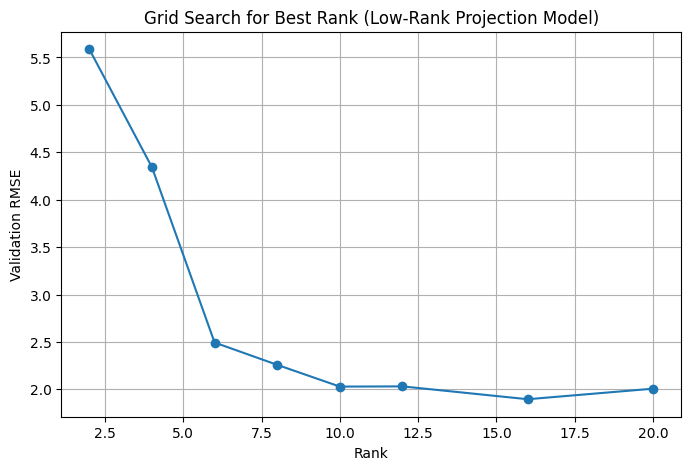

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(list(grid_results.keys()), list(grid_results.values()), marker='o')
plt.xlabel("Rank")
plt.ylabel("Validation RMSE")
plt.title("Grid Search for Best Rank (Low-Rank Projection Model)")
plt.grid(True)
plt.show()